In [1]:
import numpy as np
import tensorflow as tf
import os
from tensorflow.python.platform import gfile
import os.path
import re
import sys
import tarfile
from subprocess import Popen, PIPE, STDOUT

from pyspark.mllib.linalg import SparseVector
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.tree import RandomForest

def run(cmd):
    p = Popen(cmd, shell=True, stdin=PIPE, stdout=PIPE, stderr=STDOUT, close_fds=True)
    return p.stdout.read()


In [72]:
# All the constants to run this notebook.

model_dir = '/tmp/imagenet'
image_file = ""
num_top_predictions = 5
DATA_URL = 'http://download.tensorflow.org/models/image/imagenet/inception-2015-12-05.tgz'

IMG_URL = 'hdfs://localhost:9000/data/im10*.jpg'
TAG_URL = 'hdfs://localhost:9000/data/meta/tags/tags10*.txt'

NUM_FEATURES = 1000
NUM_MIN_OBSERVATIONS = 3


In [3]:
# list of most used tags ordered from the most to the less used
most_used_tags = sc.binaryFiles(TAG_URL).flatMap(lambda x:x[1].splitlines()).map(lambda x:(x,1)).reduceByKey(lambda x,y:x+y).sortBy(lambda x:x[1],ascending=False).take(NUM_FEATURES)

def clean_img_rdd(x):
    key = os.path.basename(x[0]).split('.')[0][2:]    
    return (key,x[1])

def clean_tags_rdd(x):
    key = os.path.basename(x[0]).split('.')[0][4:]  
    tags = x[1].splitlines()
    value = list()
    for tag in tags:
        for pos, val in enumerate(most_used_tags):
            if val[0] == tag:
                value.append(pos)    
                break
    return (key,value)
    
def read_file_index():
    im = sc.binaryFiles(IMG_URL).map(clean_img_rdd)
    tg = sc.binaryFiles(TAG_URL).map(clean_tags_rdd)
    
    return im.join(tg)


In [4]:
def maybe_download_and_extract():
    """Download and extract model tar file."""
    from six.moves import urllib
    dest_directory = model_dir
    if not os.path.exists(dest_directory):
        os.makedirs(dest_directory)
    filename = DATA_URL.split('/')[-1]
    filepath = os.path.join(dest_directory, filename)
    if not os.path.exists(filepath):
        filepath2, _ = urllib.request.urlretrieve(DATA_URL, filepath)
        print("filepath2", filepath2)
        statinfo = os.stat(filepath)
        print('Succesfully downloaded', filename, statinfo.st_size, 'bytes.')
        tarfile.open(filepath, 'r:gz').extractall(dest_directory)
    else:
        print('Data already downloaded:', filepath, os.stat(filepath))

maybe_download_and_extract()


('Data already downloaded:', '/tmp/imagenet/inception-2015-12-05.tgz', posix.stat_result(st_mode=33188, st_ino=1975180, st_dev=66309, st_nlink=1, st_uid=0, st_gid=0, st_size=88931400, st_atime=1515549575, st_mtime=1515549584, st_ctime=1515549584))


In [5]:
image_data = read_file_index()

In [6]:
label_lookup_path = os.path.join(model_dir, 'imagenet_2012_challenge_label_map_proto.pbtxt')
uid_lookup_path = os.path.join(model_dir, 'imagenet_synset_to_human_label_map.txt')

def load_lookup():
    """Loads a human readable English name for each softmax node.
    
    Args:
        label_lookup_path: string UID to integer node ID.
        uid_lookup_path: string UID to human-readable string.

    Returns:
        dict from integer node ID to human-readable string.
    """
    if not gfile.Exists(uid_lookup_path):
        tf.logging.fatal('File does not exist %s', uid_lookup_path)
    if not gfile.Exists(label_lookup_path):
        tf.logging.fatal('File does not exist %s', label_lookup_path)

    # Loads mapping from string UID to human-readable string
    proto_as_ascii_lines = gfile.GFile(uid_lookup_path).readlines()
    uid_to_human = {}
    p = re.compile(r'[n\d]*[ \S,]*')
    for line in proto_as_ascii_lines:
        parsed_items = p.findall(line)
        uid = parsed_items[0]
        human_string = parsed_items[2]
        uid_to_human[uid] = human_string

    # Loads mapping from string UID to integer node ID.
    node_id_to_uid = {}
    proto_as_ascii = gfile.GFile(label_lookup_path).readlines()
    for line in proto_as_ascii:
        if line.startswith('  target_class:'):
            target_class = int(line.split(': ')[1])
        if line.startswith('  target_class_string:'):
            target_class_string = line.split(': ')[1]
            node_id_to_uid[target_class] = target_class_string[1:-2]

    # Loads the final mapping of integer node ID to human-readable string
    node_id_to_name = {}
    for key, val in node_id_to_uid.items():
        if val not in uid_to_human:
            tf.logging.fatal('Failed to locate: %s', val)
        name = uid_to_human[val]
        node_id_to_name[key] = name

    return node_id_to_name

node_lookup = load_lookup()

node_lookup_bc = sc.broadcast(node_lookup)

In [7]:
model_path = os.path.join(model_dir, 'classify_image_graph_def.pb')
with gfile.FastGFile(model_path, 'rb') as f:
    model_data = f.read()
    
model_data_bc = sc.broadcast(model_data)


In [8]:
def run_image(sess, img_id, image, tags, node_lookup):

    scores = []
    
    softmax_tensor = sess.graph.get_tensor_by_name('softmax:0')
    predictions = sess.run(softmax_tensor,
                            {'DecodeJpeg/contents:0': image})
    predictions = np.squeeze(predictions)
    top_k = predictions.argsort()[-num_top_predictions:][::-1]
    scores = []
    for node_id in top_k:
        if node_id not in node_lookup:
            human_string = ''
        else:
            human_string = node_lookup[node_id]
        score = predictions[node_id]
        #scores.append((human_string, score))
        scores.append((node_id, score))
    return (tags, scores, img_id)

def apply_inference(image_entry):
    img_id = image_entry[0]
    image = image_entry[1][0]
    tags = image_entry[1][1]
    with tf.Graph().as_default() as g:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(model_data_bc.value)
        tf.import_graph_def(graph_def, name='')
        with tf.Session() as sess:
            labelled = run_image(sess, img_id, image, tags, node_lookup_bc.value)
            return labelled


In [9]:
# filter the images without tags -> x[1][1] are tags
# apply inference in images
inference_images = image_data.filter(lambda x: x[1][1]).map(apply_inference)

In [10]:
local_inference_images = inference_images.collect()

local_inference_images

[([187, 126, 621, 718, 523, 155, 400],
  [(761, 0.22730482),
   (819, 0.049915362),
   (382, 0.03734066),
   (958, 0.034226477),
   (336, 0.030088237)],
  u'1087'),
 ([857, 87, 402, 225, 761],
  [(57, 0.56658959),
   (12, 0.35133642),
   (155, 0.0081336638),
   (65, 0.00391897),
   (136, 0.0036721569)],
  u'1085'),
 ([144, 711, 871, 505, 586, 238],
  [(648, 0.6447764),
   (453, 0.033781823),
   (365, 0.033299211),
   (838, 0.008641962),
   (327, 0.0059704361)],
  u'1081'),
 ([832, 7, 215, 363],
  [(581, 0.054643136),
   (992, 0.042760666),
   (356, 0.035340082),
   (895, 0.031024935),
   (535, 0.028813684)],
  u'1029'),
 ([703, 686, 253, 11, 570, 54, 799, 898],
  [(967, 0.78006184),
   (942, 0.013801795),
   (992, 0.0097311018),
   (330, 0.0086515183),
   (478, 0.0053733536)],
  u'1089'),
 ([100,
   45,
   449,
   331,
   840,
   468,
   129,
   387,
   18,
   20,
   46,
   75,
   787,
   353,
   95,
   654,
   296,
   2,
   13,
   7,
   841],
  [(985, 0.68836701),
   (945, 0.14225172)

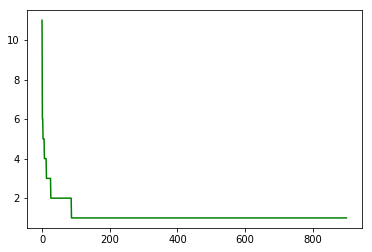

In [58]:
ids = []
values = []
names = []
for id,val in enumerate(most_used_tags):
    ids.append(id)
    values.append(val[1])
    names.append(val[0])
    
import matplotlib.pyplot as plt
plt.plot(ids, values, 'g')
plt.show()

In [33]:
def merge_tag_as_label(categories_and_tags):
    tags = categories_and_tags[0]
    categories = categories_and_tags[1]
    paired = []
    for tag in tags:
        for category in categories:
            paired.append((tag,category))
    return paired

def merge_inference_as_label(categories_and_tags):
    tags = categories_and_tags[0]
    categories = categories_and_tags[1]
    paired = []
    for category in categories:
        for tag in tags:
            paired.append((category[0],(tag,category[1])))
    return paired

#tag_as_label = inference_images.flatMap(merge_tag_as_label).aggregateByKey((),(lambda x,y: x+(y,)),(lambda x,y: x+(y,))).collect()
#inference_as_label = inference_images.flatMap(merge_inference_as_label).aggregateByKey((),(lambda x,y: x+(y,)),(lambda x,y: x+(y,))).collect()

#def merge_inference_as_label_v2(categories_and_tags):
#    tags = categories_and_tags[0]
#    categories = categories_and_tags[1]
#    paired = []
#    values = [0] * NUM_FEATURES
#    for category in categories:
#        category_id = category[0]
#        category_prob = category[1]
#        for tag in tags:
#            values[tag]=category_prob
#        paired.append((category_id,values))
#    return paired


In [80]:
# creamos un vector de features con cada categoria como label
def merge_inference_as_label_v3(categories_and_tags):
    tags = categories_and_tags[0]
    categories = categories_and_tags[1]
    paired = []
    for category in categories:
        category_id = category[0]
        category_prob = category[1]
        paired.append((category_id,[SparseVector(NUM_FEATURES, sorted(tags), [category_prob]*len(tags))])) 
    return paired


# merge images and tags
inference_as_label_dataset = inference_images.flatMap(merge_inference_as_label_v3).reduceByKey(lambda x,y: x+y)


[(34,
  [SparseVector(1000, {41: 0.0661, 55: 0.0661, 66: 0.0661, 317: 0.0661, 320: 0.0661, 350: 0.0661, 445: 0.0661, 459: 0.0661, 491: 0.0661, 600: 0.0661, 640: 0.0661, 885: 0.0661})]),
 (874,
  [SparseVector(1000, {299: 0.0623, 312: 0.0623, 357: 0.0623, 454: 0.0623, 526: 0.0623, 866: 0.0623, 875: 0.0623, 894: 0.0623}),
   SparseVector(1000, {9: 0.7025, 17: 0.7025, 18: 0.7025, 21: 0.7025, 23: 0.7025, 24: 0.7025, 45: 0.7025, 82: 0.7025, 147: 0.7025, 200: 0.7025, 239: 0.7025, 361: 0.7025, 376: 0.7025, 442: 0.7025, 547: 0.7025, 561: 0.7025, 606: 0.7025, 619: 0.7025, 651: 0.7025, 689: 0.7025, 699: 0.7025, 814: 0.7025, 817: 0.7025, 821: 0.7025, 846: 0.7025, 855: 0.7025, 858: 0.7025, 896: 0.7025})]),
 (338,
  [SparseVector(1000, {19: 0.0312, 122: 0.0312, 148: 0.0312, 193: 0.0312, 211: 0.0312, 346: 0.0312, 418: 0.0312, 432: 0.0312, 461: 0.0312, 471: 0.0312, 524: 0.0312, 556: 0.0312, 562: 0.0312, 639: 0.0312, 668: 0.0312, 671: 0.0312, 754: 0.0312, 801: 0.0312, 836: 0.0312, 850: 0.0312, 893: 0.

In [104]:
categories_to_train = inference_images.flatMap(lambda x:x[1]).map(lambda x:(x[0],1)).reduceByKey(lambda x,y:x+y).filter(lambda x:x[1]>NUM_MIN_OBSERVATIONS).sortBy(lambda x:x[0]).map(lambda x:x[0]).collect()

def merge_inference_as_label_v4(categories_and_tags):
    tags = categories_and_tags[0]
    categories = categories_and_tags[1]
    paired = []
    for category in categories:
        category_id = category[0]
        category_prob = category[1]
        paired.append((category_id,SparseVector(NUM_FEATURES, sorted(tags), [category_prob]*len(tags))))
    return paired

observation_data = inference_images.flatMap(merge_inference_as_label_v4)

observation_data.collect()

[(761,
  SparseVector(1000, {126: 0.2273, 155: 0.2273, 187: 0.2273, 400: 0.2273, 523: 0.2273, 621: 0.2273, 718: 0.2273})),
 (819,
  SparseVector(1000, {126: 0.0499, 155: 0.0499, 187: 0.0499, 400: 0.0499, 523: 0.0499, 621: 0.0499, 718: 0.0499})),
 (382,
  SparseVector(1000, {126: 0.0373, 155: 0.0373, 187: 0.0373, 400: 0.0373, 523: 0.0373, 621: 0.0373, 718: 0.0373})),
 (958,
  SparseVector(1000, {126: 0.0342, 155: 0.0342, 187: 0.0342, 400: 0.0342, 523: 0.0342, 621: 0.0342, 718: 0.0342})),
 (336,
  SparseVector(1000, {126: 0.0301, 155: 0.0301, 187: 0.0301, 400: 0.0301, 523: 0.0301, 621: 0.0301, 718: 0.0301})),
 (57,
  SparseVector(1000, {87: 0.5666, 225: 0.5666, 402: 0.5666, 761: 0.5666, 857: 0.5666})),
 (12,
  SparseVector(1000, {87: 0.3513, 225: 0.3513, 402: 0.3513, 761: 0.3513, 857: 0.3513})),
 (155,
  SparseVector(1000, {87: 0.0081, 225: 0.0081, 402: 0.0081, 761: 0.0081, 857: 0.0081})),
 (65,
  SparseVector(1000, {87: 0.0039, 225: 0.0039, 402: 0.0039, 761: 0.0039, 857: 0.0039})),
 (13

In [98]:
categories_to_train = [330]

In [105]:
def merge_inference_as_labeledpoint(observation,category_target):
    if observation[0] == category_target:
        return LabeledPoint(1,observation[1])
    else:
        return LabeledPoint(0,observation[1])

def train_randomforest_model(dataset):
    
    model = RandomForest.trainClassifier(dataset, 2, {}, 3, seed=42)
    
    return model

models = []

for category_target in categories_to_train:
    print("Training category {} ({})".format(node_lookup[category_target],category_target))
    observation_data_labeled = observation_data.map(lambda x: merge_inference_as_labeledpoint(x,category_target)).collect()
    print(observation_data_labeled)
    models.append(category_target,train_randomforest_model(observation_data_labeled))
    
print(models)

Training category rapeseed (330)


KeyboardInterrupt: 

# PREDICTION FOR THE FUTURE


In [ ]:
def score(model):
    predictions = model.predict(test_data.map(lambda x: x.features))
    labels_and_preds = test_data.map(lambda x: x.label).zip(predictions)
    accuracy = labels_and_preds.filter(lambda x: x[0] == x[1]).count() / float(test_data.count())
    return accuracy

# Old approach:


In [47]:
# merge images and tags
# filters inferences with more than 50% of probability
inference_as_label = inference_images.flatMap(merge_inference_as_label).filter(lambda x:x[1][1]>0.5).aggregateByKey(list(),(lambda x,y: x+list((y,))),(lambda i,j: i+j)).filter(lambda x:len(x[1])>1).collect()

inference_as_label

[(596,
  [('louisville', 0.72243607),
   ('kentucky', 0.72243607),
   ('skyline', 0.72243607),
   ('indiana', 0.72243607),
   ('fallsoftheohio', 0.72243607),
   ('1855mm', 0.72243607)]),
 (944,
  [('washington', 0.89433146),
   ('wa', 0.89433146),
   ('spaceneedle', 0.89433146),
   ('skyline', 0.89433146),
   ('seattle', 0.89433146),
   ('panorama', 0.89433146),
   ('elliottbay', 0.89433146),
   ('clouds', 0.89433146),
   ('city', 0.89433146)]),
 (330,
  [('northside', 0.62856919),
   ('pittsburgh', 0.62856919),
   ('eastallegheny', 0.62856919),
   ('sky', 0.62856919),
   ('clouds', 0.62856919)]),
 (722,
  [('1776', 0.99851483),
   ('independenceday', 0.99851483),
   ('july4th', 0.99851483),
   ('america', 0.99851483),
   ('flag', 0.99851483),
   ('bundting', 0.99851483)]),
 (774,
  [('bomk', 0.50299728),
   ('book', 0.50299728),
   ('livre', 0.50299728),
   ('interview', 0.50299728),
   ('ekosystemorg', 0.50299728),
   ('ekosystem', 0.50299728),
   ('vitostreet', 0.50299728),
   ('edi

In [21]:
tag_as_label = inference_images.flatMap(merge_tag_as_label).filter(lambda x:x[1][1]>0.2).aggregateByKey(list(),(lambda x,y: x+list((y,))),(lambda i,j: i+j)).filter(lambda x:len(x[1])>1).collect()

tag_as_label

[('sodiumhydroxide', [(971, 0.43217739), (781, 0.37137467)]),
 ('doily', [(836, 0.23864704), (815, 0.23522472)]),
 ('soe', [(220, 0.44202313), (545, 0.74752247)]),
 ('giant', [(836, 0.23864704), (815, 0.23522472)]),
 ('sky',
  [(503, 0.93601441),
   (367, 0.77648342),
   (545, 0.74752247),
   (596, 0.86975491),
   (245, 0.41936967)]),
 ('texture', [(938, 0.20166412), (647, 0.43266514)]),
 ('black',
  [(593, 0.99846905),
   (415, 0.22868274),
   (330, 0.21981542),
   (245, 0.41936967)]),
 ('tweed', [(836, 0.23864704), (815, 0.23522472)]),
 ('me', [(967, 0.33025736), (971, 0.43217739), (781, 0.37137467)]),
 ('blanket', [(836, 0.23864704), (815, 0.23522472)]),
 ('closeup', [(224, 0.29146379), (745, 0.76611984)]),
 ('uyma', [(972, 0.34671441), (751, 0.3281346)]),
 ('toronto', [(967, 0.33025736), (220, 0.46368244)]),
 ('\xc3\xa7i\xc3\xa7ek', [(415, 0.22868274), (330, 0.21981542)]),
 ('vivitar', [(971, 0.43217739), (781, 0.37137467)]),
 ('causticsoda', [(971, 0.43217739), (781, 0.37137467)])